In [1]:
import distmesh as dm
import numpy as np
import math
import scipy
from scipy.sparse import csr_matrix,lil_matrix
from scipy.sparse import diags
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size': 20}) # set font size in all plots

pi = math.pi

In [2]:
# FEM matrix constructors

# Function for stiffness matrix. 
# Adapted from https://github.com/mar1akc/transition_path_theory_FEM_distmesh/blob/main/FEM_TPT.py
def stima3(verts):
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    rhs = np.zeros((3,2))
    rhs[1,0] = 1
    rhs[2,1] = 1
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    M = 0.5*np.linalg.det(Aux)*np.matmul(G,np.transpose(G))
    return M

# from distmesh without tri
def triarea(pts):
    # calculates areas of mesh triangle
    # p = [x_vec,y_vec]
    d12 = pts[1,:]-pts[0,:]
    d13 = pts[2,:]-pts[0,:]
    return d12[0]*d13[1]-d12[1]*d13[0]

# Function for mass matrix.
def massma3(verts):
    Aux = np.ones((3,3))
    np.fill_diagonal(Aux,2)
    return triarea(verts)/24*Aux

# load vector
def load(verts):
    return triarea(verts)/6

count =  200 displacement =  0.1351605323701454
count =  400 displacement =  0.2310880078009986
count =  600 displacement =  0.041265976740194936
count =  800 displacement =  0.050450390709307555
count =  1000 displacement =  0.04573153566605065
count =  1200 displacement =  0.015787215087993977
count =  1400 displacement =  0.012458603337079918
count =  1600 displacement =  0.023436875776460045
count =  1800 displacement =  0.16081427948764299
count =  2000 displacement =  0.005919966951089667
count =  2200 displacement =  0.002558275704986128
count =  2400 displacement =  0.0016973155272764693
count =  2600 displacement =  0.0012861104013179962


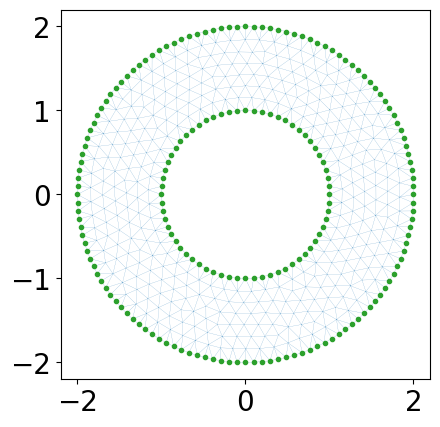

In [3]:
# construct total region
d_annulus = lambda p: dm.ddiff(dm.dcircle(p,0,0,2),dm.dcircle(p,0,0,1))

# fixed points
h0 = 2*pi/64
n = int(np.round(2*pi/h0))
pfix = [[math.cos(2*pi*i/n), math.sin(2*pi*i/n)] for i in range(n)] # inner
pfix.extend([[2*math.cos(pi*i/n), 2*math.sin(pi*i/n)] for i in range(2*n)]) # outer
# solve system
[pts,tri] = dm.distmesh2D(d_annulus, dm.huniform, h0/8, [-1, 1, -1, 1], pfix)
Npts,Ntri = len(pts),len(tri)

# ax.set_aspect(1)
plt.plot([p[0] for p in pfix], [p[1] for p in pfix],'.')

In [4]:
# unit conversions
def Cart2Polar(pts):
    r = np.sqrt(pts[:,0]**2+pts[:,1]**2)
    theta = np.arctan2(pts[:,1],pts[:,0])
    return r,theta

def plotAnnulus(pts,tri,u,title,label):
    fig = plt.figure(figsize =(8, 8))
    ax = plt.axes()

    plot = ax.tripcolor(pts[:,0],pts[:,1],u,triangles=tri)
    fig.colorbar(plot)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.title(title)
    plt.savefig(label)
    
r,theta = Cart2Polar(pts)

In [5]:
# indices for points on D0, D1, Neuman Boundary
IDir = [i for i in range(Npts) if abs(r[i]-1) < h0/4 or abs(r[i]-2) < h0/4]
# indices for free points
Ifree = [i for i in range(len(pts)) if i not in IDir]
Ifreegrid = np.ix_(Ifree,Ifree)


# initialize matrices
A = lil_matrix((Npts,Npts), dtype = float)
B = lil_matrix((Npts,Npts), dtype = float)
b = np.zeros(Npts)

for j in range(Ntri):
    v = pts[tri[j,:],:] # vertices of mesh triangle
    vmid = np.reshape(np.sum(v,axis=0)/3,(1,2)) # midpoint of mesh triangle
    ind = tri[j,:]
    indt = np.array(ind)[:,None]
    A[indt,ind] = A[indt,ind] + stima3(v)
    B[indt,ind] = B[indt,ind] + massma3(v)
    b[ind] = b[ind] + load(v)

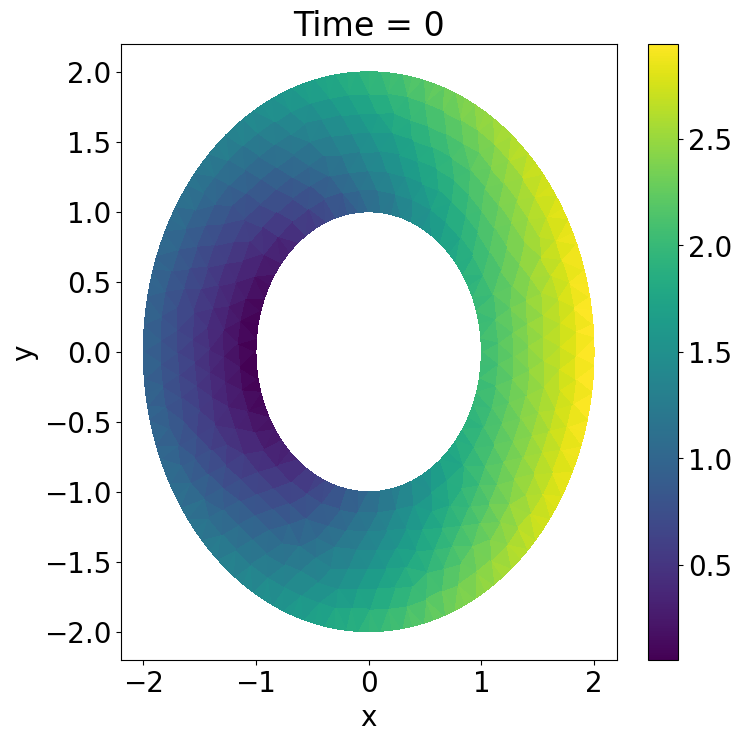

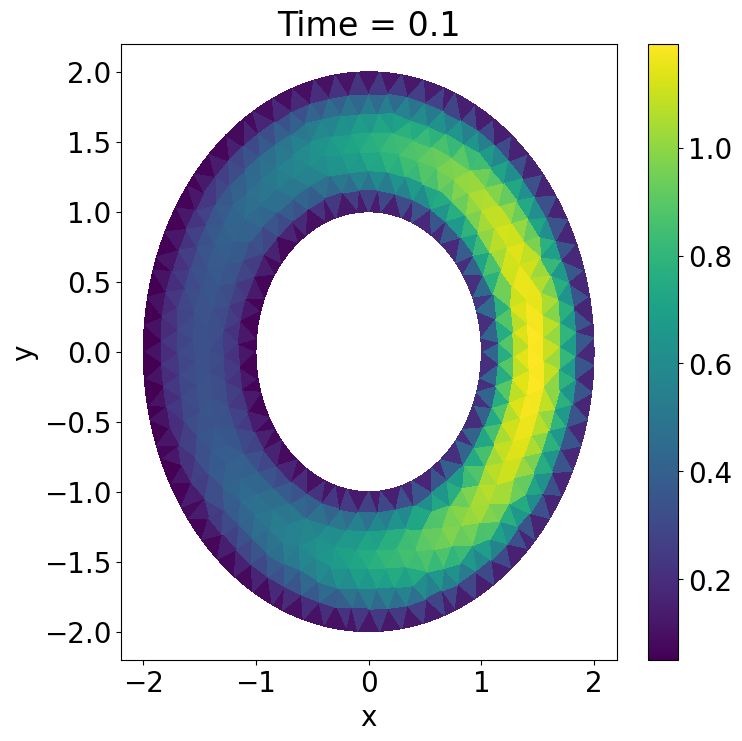

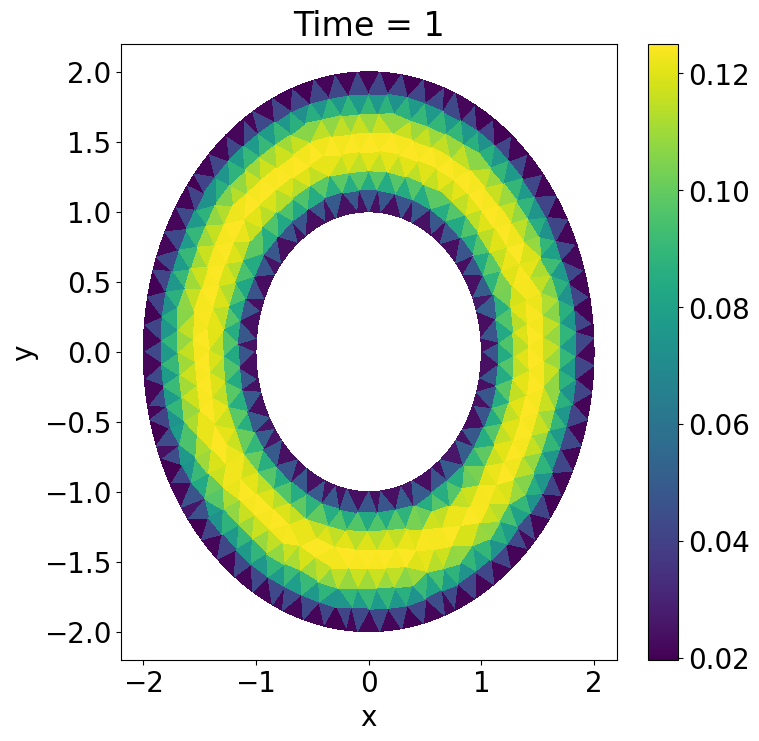

In [6]:
# setup to solve system
# initial conditions and time values
dt = 0.01
times = np.arange(0,1+dt,step=dt)
U = np.zeros((len(pts),len(times)))
r,theta = Cart2Polar(pts)
U[:,0] = r + np.cos(theta)

plotAnnulus(pts,tri,U[:,0],title = 'Time = 0', label = 't0.pdf')

# run time stepping
for n in range(len(times)-1):
    # (B+dt/2*A)U^{n+1} = (B-dt/2*A)U^n + dt*b
    RHS = (B[Ifreegrid]-dt/2*A[Ifreegrid])@U[Ifree,n]+dt*b[Ifree]
    M = B[Ifreegrid]+dt/2*A[Ifreegrid]
    U[Ifree,n+1] = scipy.sparse.linalg.spsolve(M,RHS)
    
plotAnnulus(pts,tri,U[:,int(0.1/dt)],title = 'Time = 0.1', label = 't01.pdf')
plotAnnulus(pts,tri,U[:,-1],title = 'Time = 1', label = 't10.pdf')

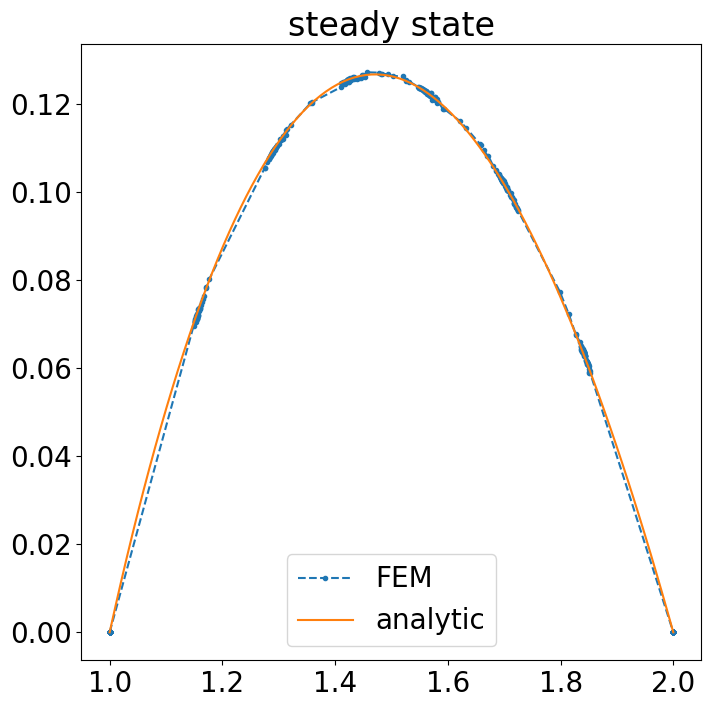

In [7]:
fig = plt.figure(figsize =(8, 8))
ax = plt.axes()
# numerical solution
rsort,u1sort = zip(*sorted(zip(r,U[:,-1])))
ax.plot(rsort,u1sort,'.--')
# analytic solution
rspaced = np.linspace(1,2,100)
ax.plot(rspaced,(1-rspaced**2)/4+3*np.log(rspaced)/4/np.log(2))
ax.set_title('steady state')
ax.legend(['FEM','analytic'])

plt.savefig('SteadyStateErr.pdf')